In [30]:
import importlib
import cv2

import yolo_pose as y
import face_landmark as f

importlib.reload(y)
importlib.reload(f)

<module 'face_landmark' from 'c:\\Users\\Tian_\\Documents\\School\\Meng\\AER 1515\\Project\\face_landmark.py'>

In [21]:
# face mesh stuff
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='./face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("./datasets/coco8-pose/images/train/000000000036.jpg")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = f.draw_landmarks_on_image(image.numpy_view(), detection_result)
print(annotated_image.shape)
cv2.imshow("face mesh", cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()


NormalizedLandmark(x=0.5342509746551514, y=0.40201377868652344, z=-0.027224399149417877, visibility=0.0, presence=0.0)
(640, 481, 3)


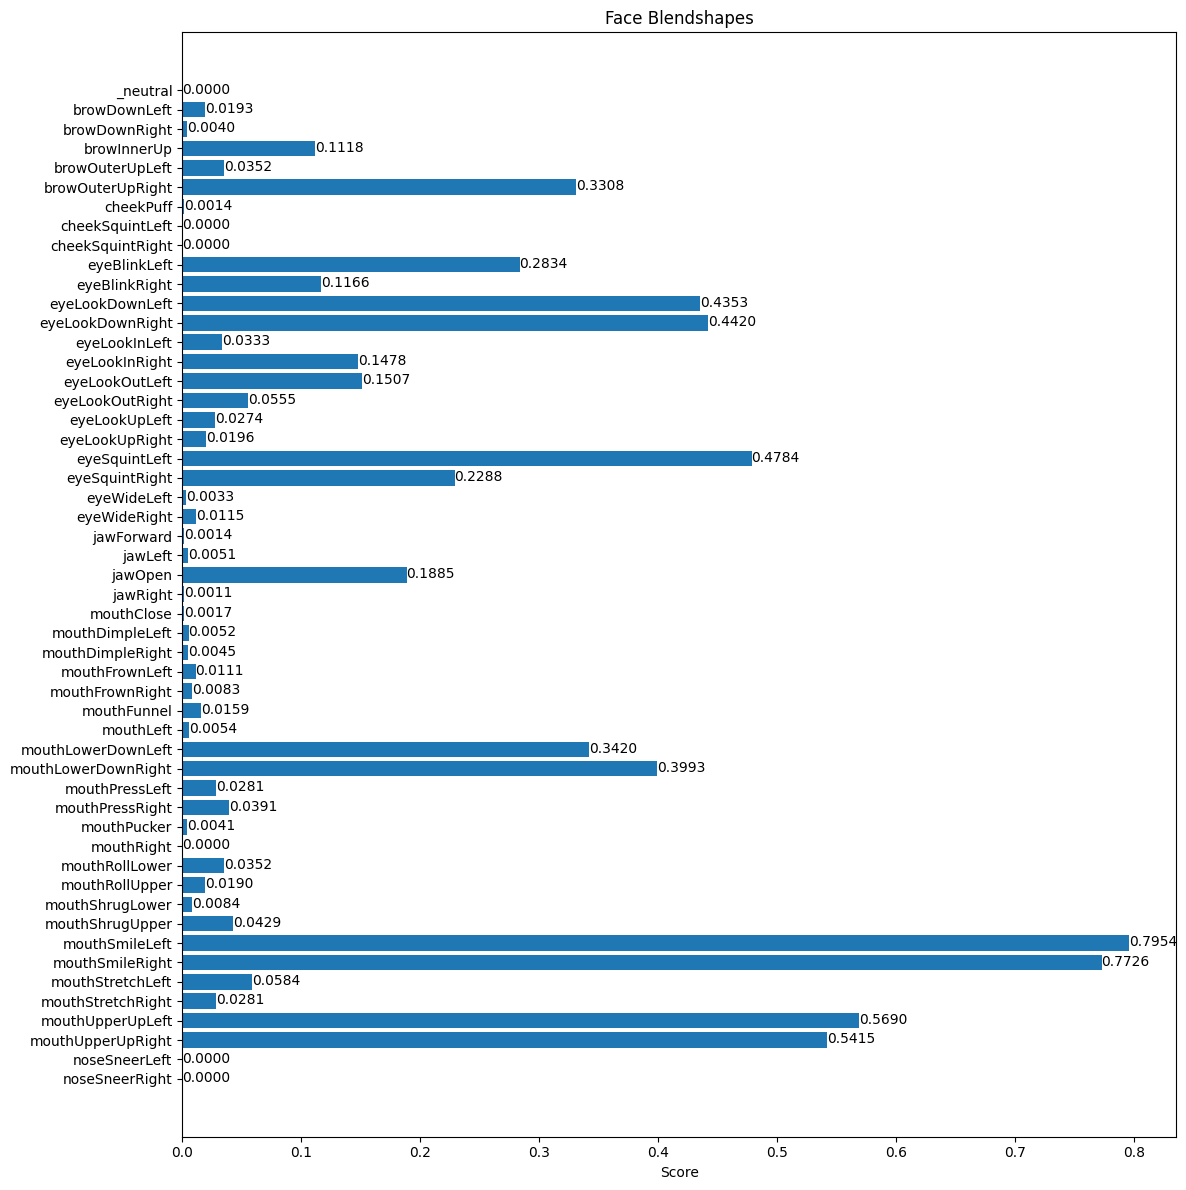

In [13]:
f.plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [57]:
import numpy as np
import visualize_robot_pov_plotly as v
import pickle
import importlib
import matplotlib.pyplot as plt
import torch.nn as nn
import lstm_model as m
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score
import torch.utils.data as data
import torch
import data_processing as d
from IPython.display import HTML

importlib.reload(v)
importlib.reload(m)
importlib.reload(d)
from visualize_robot_pov_plotly import DataPointSet

In [ ]:
# load data 
dir = "../datasets/processed/preproc_out_2.pkl"
with open(dir, "rb") as f:
    robot_trajs, human_trajs = pickle.load(f) # robot traj not trained on, just for reference

In [16]:
print(human_trajs[1].data_points.keys())

dict_keys(['ankle_left', 'ankle_right', 'ear_left', 'ear_right', 'elbow_left', 'elbow_right', 'eye_left', 'eye_right', 'hip_left', 'hip_right', 'knee_left', 'knee_right', 'nose', 'shoulder_left', 'shoulder_right', 'wrist_left', 'wrist_right'])


In [ ]:
x_data_list, y_data_list = d.convert_dptset_list(human_trajs)
X, y = d.create_sequences(x_data_list, 25, 5, label_arr_list = y_data_list, time_offset_secs=5)
data_dim = X.shape[1]
# X = d.scale_seq(X)
n, seq_len, dim = X.shape

print(X.shape)
print(np.sum(y))
print(torch.version.cuda)
print(torch.cuda.is_available())
train_loader, val_loader = d.create_dataloaders(X, y)

(17109, 25, 34)
12.8
True


In [77]:
%matplotlib notebook 
# inline

i = np.random.randint(len(X))
ani = d.plot_validate(X[i])
display(HTML(ani.to_jshtml()))

<IPython.core.display.Javascript object>

In [70]:
import torch.optim as optim

# Hyperparameters
epochs = 100
lr = 0.01
batch_size = 32
patience = 15

train_precis = 0
train_recall = 0

val_precis = 0
val_recall = 0

history = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"training on {device}")
model = m.SimpleLSTM(input_size = dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Simple training loop
min_val_loss = None
patience_tracker = 0
best_epoch = 0
for epoch in range(epochs):
    train_rates = np.array([0,0,0,0])
    val_rates = np.array([0,0,0,0])

    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)

        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)

        rates = d.get_rates(y_batch.to("cpu"), y_pred.to("cpu"))
        train_rates += rates

    train_loss /= len(train_loader.dataset)
    train_precis, train_recall = d.get_precis_recall(train_rates)
    history = d.add_dict_list(history, "train_loss", train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * x_batch.size(0)

            rates = d.get_rates(y_batch.to("cpu"), y_pred.to("cpu"))
            val_rates += rates

    val_loss /= len(val_loader.dataset)

    val_precis, val_recall = d.get_precis_recall(val_rates)
    history = d.add_dict_list(history, "val_loss", val_loss)

    if (epoch+1) % 10 == 0 or True:
        print(f"Epoch {epoch+1}/{epochs}, train loss: {train_loss:.4f}, prec: {train_precis:.4f}, rec: {train_recall:.4f}, rates: {train_rates} | val loss: {val_loss:.4f}, prec: {val_precis:.4f}, rec: {val_recall:.4f}, rates: {val_rates}")
    
    # early stopping
    if min_val_loss is None or min_val_loss > val_loss:
        min_val_loss = val_loss
        patience_tracker = 0
        best_model_wts = model.state_dict()
        best_epoch = epoch
    else:
        patience_tracker += 1

    if patience_tracker >= patience:
        print(f"early stopping, reverting to best epoch: {best_epoch}")
        model.load_state_dict(best_model_wts)
        break

training on cuda
Epoch 1/100, train loss: 0.4977, prec: 0.6956, rec: 0.5628, rates: [2022 5788  885 1571] | val loss: 0.4535, prec: 0.7862, rec: 0.6037, rates: [1412 4120  384  927]
Epoch 2/100, train loss: 0.4097, prec: 0.7625, rec: 0.6941, rates: [2494 5896  777 1099] | val loss: 0.4117, prec: 0.6788, rec: 0.8375, rates: [1959 3577  927  380]
Epoch 3/100, train loss: 0.3764, prec: 0.7927, rec: 0.7303, rates: [2624 5987  686  969] | val loss: 0.3720, prec: 0.7659, rec: 0.7443, rates: [1741 3972  532  598]
Epoch 4/100, train loss: 0.3626, prec: 0.8037, rec: 0.7281, rates: [2616 6034  639  977] | val loss: 0.3805, prec: 0.8891, rec: 0.5622, rates: [1315 4340  164 1024]
Epoch 5/100, train loss: 0.3488, prec: 0.8187, rec: 0.7314, rates: [2628 6091  582  965] | val loss: 0.3533, prec: 0.8653, rec: 0.6704, rates: [1568 4260  244  771]
Epoch 6/100, train loss: 0.3406, prec: 0.8352, rec: 0.7334, rates: [2635 6153  520  958] | val loss: 0.3498, prec: 0.8000, rec: 0.7627, rates: [1784 4058  446

In [74]:
# save the model
import os

save_dir = "./models"
save_path = os.path.join(save_dir, "model.pth")
torch.save(model.state_dict(), save_path)

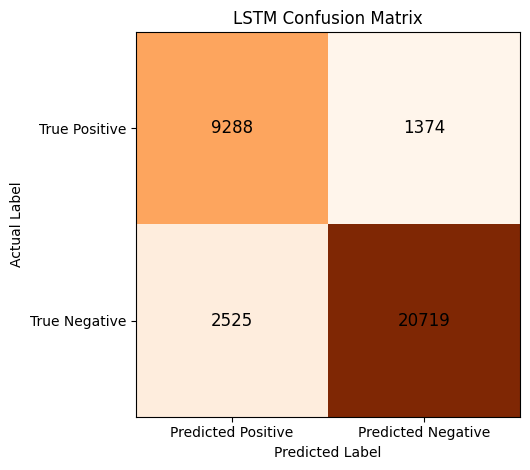

In [ ]:
arr = [9288, 20719, 2525, 1374]
d.plot_confusion_matrix(arr)